In [99]:
import numpy as np
from hmmlearn import hmm
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib  # matplotlibの日本語化
import networkx as nx


### 課題１

In [100]:
file_path = 'data.csv'

# データの読み込み
data = pd.read_csv(file_path, header=None)
sequences = data.values

# 隠れ状態の数の候補
state_numbers = range(1, 11)

# BICを格納するためのリスト
bic_scores = []

# 異なる状態数でモデルを訓練し、BICを計算
for n_states in state_numbers:
    model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=500)
    model.fit(sequences)
    
    # モデルの対数尤度
    log_likelihood = model.score(sequences)
    
    # パラメータの数
    n_params = n_states ** 2 + 2 * n_states * sequences.shape[1] - 1
    
    # BICの計算
    bic = -2 * log_likelihood + n_params * np.log(sequences.shape[0])
    bic_scores.append(bic)

# 最適な状態数を選択
optimal_state_number = state_numbers[np.argmin(bic_scores)]

# 最適な状態数でHMMを訓練
optimal_model = hmm.GaussianHMM(n_components=optimal_state_number, covariance_type="diag", n_iter=500)
optimal_model.fit(sequences)

print(f"選択された最適な隠れ状態の数: {optimal_state_number}")
print("遷移確率行列:")
print(optimal_model.transmat_)
print("\n平均:")
print(optimal_model.means_)
print("\n分散:")
print(optimal_model.covars_)

選択された最適な隠れ状態の数: 5
遷移確率行列:
[[3.70909090e-01 3.09090908e-01 6.03725878e-18 8.32149028e-28
  3.20000002e-01]
 [4.08653846e-01 3.60576923e-01 2.30769231e-01 3.56576516e-25
  8.89476060e-15]
 [1.68722455e-35 3.00000000e-01 4.87500000e-01 2.12500000e-01
  2.54828447e-28]
 [7.11482826e-31 6.19317078e-32 1.85792351e-01 5.08196723e-01
  3.06010926e-01]
 [5.08670525e-01 7.18303751e-22 1.02563209e-26 3.23699417e-01
  1.67630058e-01]]

平均:
[[8.06312033e+00 5.68709236e-03]
 [7.25658793e-02 7.03244564e+00]
 [1.01016772e+01 6.93979334e+00]
 [1.96064666e+00 8.98977671e-02]
 [4.93561442e+00 9.93766221e+00]]

分散:
[[[0.49665846 0.        ]
  [0.         0.54566662]]

 [[0.50255064 0.        ]
  [0.         0.60208196]]

 [[0.53806596 0.        ]
  [0.         0.53715645]]

 [[0.58043639 0.        ]
  [0.         0.46082433]]

 [[0.51198299 0.        ]
  [0.         0.60551196]]]


### 課題２

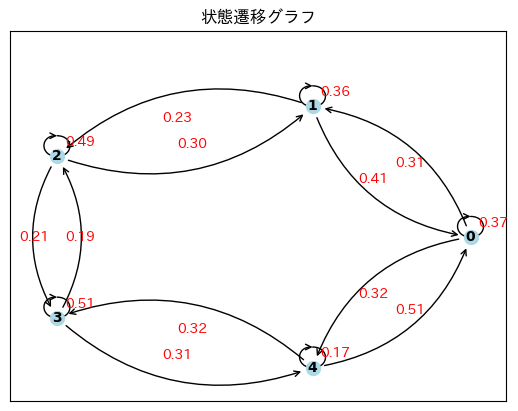

In [140]:
import matplotlib.pyplot as plt
import networkx as nx

# 遷移確率行列をグラフに変換
G = nx.DiGraph()

# グラフのノードを追加
for state in range(optimal_state_number):
    G.add_node(state)

# グラフのエッジとエッジの重み（遷移確率）を追加
for i, origin_state in enumerate(optimal_model.transmat_):
    for j, transition_probability in enumerate(origin_state):
        # 一定の閾値を超える遷移確率を持つエッジのみを追加
        if transition_probability > 0.01:
            G.add_edge(i, j, weight=transition_probability)

# グラフの描画
pos = nx.circular_layout(G)  # ノードを円形に配置

# エッジの描画
# 逆方向のエッジが重ならないように、エッジの描画スタイルを変更
edge_style = {'arrowstyle': '->', 'connectionstyle': 'arc3,rad=0.3'}
for edge in G.edges():
    nx.draw_networkx_edges(G, pos, edgelist=[edge], **edge_style)

# ノードの描画
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

# エッジの重み（遷移確率）を描画
edge_labels = {}
for edge in G.edges():
    weight = G.edges[edge]['weight']
    edge_labels[edge] = f"{weight:.2f}"
    # エッジの中点を計算
    midpoint = ((pos[edge[0]][0] + pos[edge[1]][0]) / 2, (pos[edge[0]][1] + pos[edge[1]][1]) / 2)
    # 自分自身へのエッジの場合、ラベル表示位置をノード中心から少し離す
    if edge[0] == edge[1]:
        offset_dx, offset_dy = 0.1, 0.1  # オフセット量
        midpoint = (midpoint[0] + offset_dx, midpoint[1] + offset_dy)
    # 逆方向のエッジが存在する場合、ラベル表示位置をエッジに近い位置に移動
    elif (edge[1], edge[0]) in G.edges():
        dx, dy = pos[edge[1]][0] - pos[edge[0]][0], pos[edge[1]][1] - pos[edge[0]][1] # [dx, dy]はedge[0]からedge[1]へのベクトル
        dx, dy = dy, -dx # ベクトル [dx, dy] を270度回転してエッジに垂直なベクトルにする
        norm = np.sqrt(dx ** 2 + dy ** 2)
        if norm != 0:
            offset_dx, offset_dy = dx / norm * 0.1, dy / norm * 0.1  # ラベルをエッジに近づけるオフセット量
            midpoint = (midpoint[0] + offset_dx, midpoint[1] + offset_dy)

    # ラベルを描画
    plt.text(midpoint[0], midpoint[1], edge_labels[edge], fontsize=10, ha='center', va='center', color='red')

plt.title('状態遷移グラフ')
plt.show()
